### A simulation analysis for seeing what abstractness can tell us about geometry
- create units from linear encoding model 
- inject some noise
- look at the decoder axes, CCGP in relation to noise, encoding projection axes

In [2]:
import numpy as np
from scipy.stats import ortho_group
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

### 1st simulation: 
- two values, v1, v2, randomly sampled from uniform dist of [0, 1]
- encoding axes of 100 neurons orthgonal (beta1, beta2): 
$$ r = \beta_1 v_1 + \beta_2 v_2 + \epsilon $$
- Define decoding target as whether max value < median
- Two conditions: v1 < v2, v1 > v2

In [4]:
def get_orthogonal_betas(num_units, num_vars):
    """
    Returns reps that will be shape [num_units, num_vars]
    """
    m = ortho_group.rvs(dim=num_units)
    return m[:, :num_vars]

def get_two_betas_with_angle(num_units, theta):
    orth = get_orthogonal_betas(num_units, 2)
    a = np.tan((np.pi / 2 - theta) /2)
    res = np.empty((num_units, 2))
    res[:, 0] = orth[:, 0] + a * orth[:, 1]
    res[:, 1] = orth[:, 1] + a * orth[:, 0]
    res[:, 0] = res[:, 0] / np.linalg.norm(res[:, 0])
    res[:, 1] = res[:, 1] / np.linalg.norm(res[:, 1])
    return res

def get_random_values(num_trials, num_vars, rng):
    """
    Returns values that will be of shape [num_vars, num_trials]
    """
    return rng.uniform(0, 1, size=(num_vars, num_trials))

def get_random_values_gaussian(num_trials, num_vars, rng):
    return rng.normal(0, 1, size=(num_vars, num_trials))

def simulate_neural_activity(betas, vars, rng, noise_std):
    noise = rng.normal(0, noise_std, size=(betas.shape[0], vars.shape[1]))
    return betas @ vars + noise

def get_labels(vars):
    maxes = np.max(vars, axis=0)
    median = np.median(maxes)
    labels = maxes <= median
    return labels

def get_labels_entropy(vars):
    entropies = scipy.stats.entropy(vars)
    median = np.median(entropies)
    labels = entropies >= median
    return labels

def get_labels_dist(vars):
    dists = np.linalg.norm(vars, axis=0)
    median = np.median(dists)
    labels = dists >= median
    return labels

def get_idxs_by_condition(vars):
    idxs_by_condition = []
    for i in range(vars.shape[0]):
        vals_for_var = vars[i, :]
        idxs = np.where(np.all(vars <= vals_for_var, axis=0))[0]
        idxs_by_condition.append(idxs)
    return idxs_by_condition

def train_model(frs, labels):
    x_train, x_test, y_train, y_test = train_test_split(frs.T, labels)
    model = LogisticRegression(penalty=None)
    model = model.fit(x_train, y_train)
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    return model, train_score, test_score

def evaluate_model(model, frs, labels):
    _, x_test, _, y_test = train_test_split(frs.T, labels)
    test_score = model.score(x_test, y_test)
    return test_score

def evaluate_ccgp(frs, labels, idxs_by_condition, num_samples=10):
    in_cond_res = []
    cross_cond_res = []
    overall_res = []
    for condition, idxs in enumerate(idxs_by_condition):
        idxs = idxs_by_condition[condition]
        other_idxs_by_condition = [idxs for i, idxs in enumerate(idxs_by_condition) if i != condition]
        for _ in range(num_samples):
            condition_frs = frs[:, idxs]
            condition_labels = labels[idxs]
            model, _, test_score = train_model(condition_frs, condition_labels)
            in_cond_res.append(test_score)

            overall_model, _, overall_test_score = train_model(frs, labels)
            overall_res.append(overall_test_score)

            for other_idxs in other_idxs_by_condition:
                other_frs = frs[:, other_idxs]
                other_labels = labels[other_idxs]
                other_test_score = evaluate_model(model, other_frs, other_labels)
                cross_cond_res.append(other_test_score)
    return in_cond_res, cross_cond_res, overall_res

def calc_cosine_sim(vec_a, vec_b):
    return vec_a.dot(vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

def calc_angle(vec_a, vec_b):
    return np.arccos(calc_cosine_sim(vec_a, vec_b))



In [3]:
num_units = 100
num_vars = 2
num_trials = 1000
rng = np.random.default_rng()
betas = get_orthogonal_betas(num_units, num_vars)
vars = get_random_values(num_trials, 2, rng)
frs = simulate_neural_activity(betas, vars, rng, 2)
labels = get_labels(vars)
idxs_by_condition = get_idxs_by_condition(vars)
idxs_by_condition_w_all = [np.arange(vars.shape[1])] + idxs_by_condition
condition_names = ["all", "v0 > v1", "v1 > v0"]

### Plot the true labels in value space

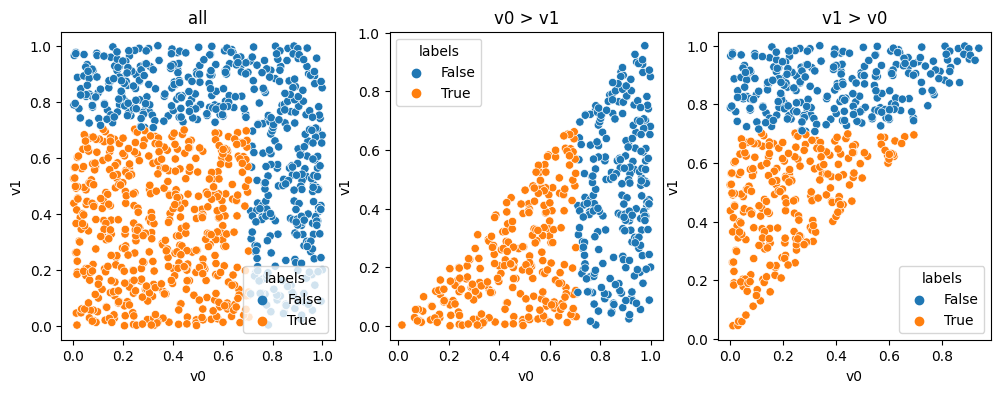

In [4]:
fig, axs = plt.subplots(1, len(idxs_by_condition_w_all), figsize=(12, 4))
for i, idxs in enumerate(idxs_by_condition_w_all):
    ax = axs[i]
    value_df = pd.DataFrame({"v0": vars[0, idxs], "v1": vars[1, idxs], "labels": labels[idxs]})
    sns.scatterplot(data=value_df, x="v0", y="v1", hue="labels", ax=ax)
    ax.set_title(condition_names[i])


### What do the decoding axes look like projected back into value space as a func of noise?

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

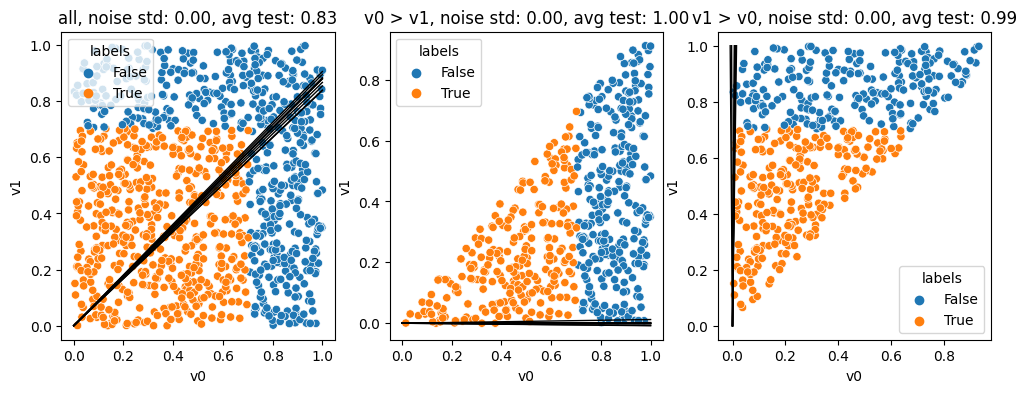

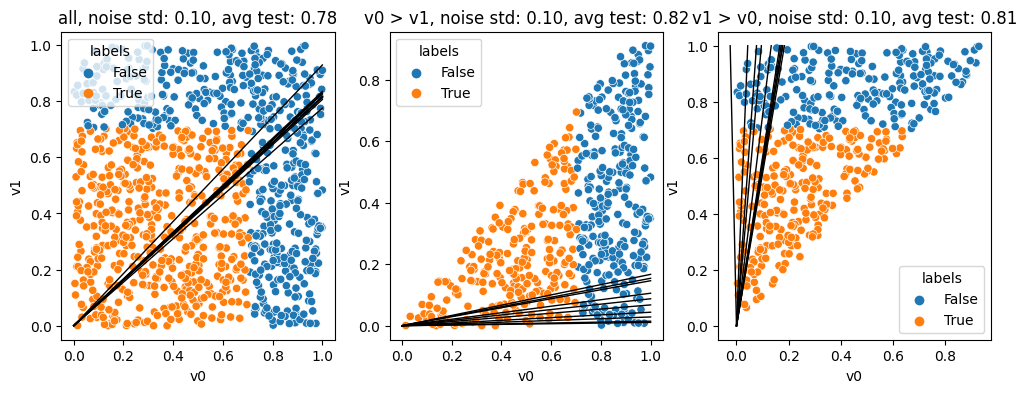

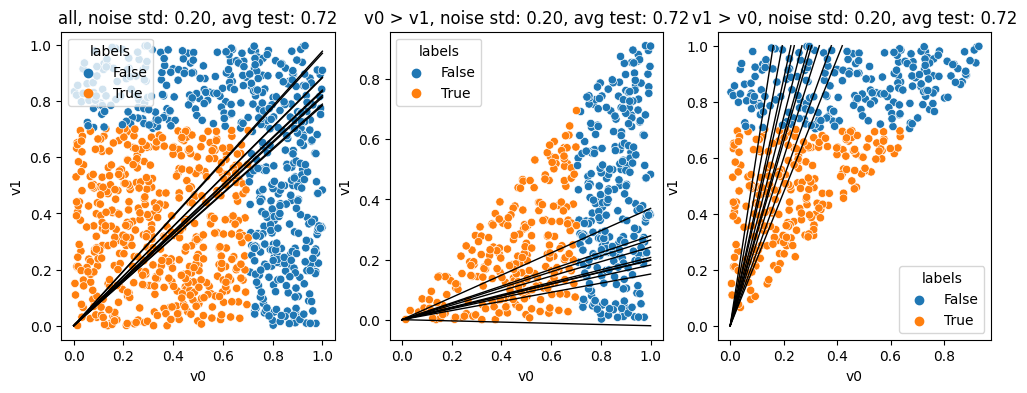

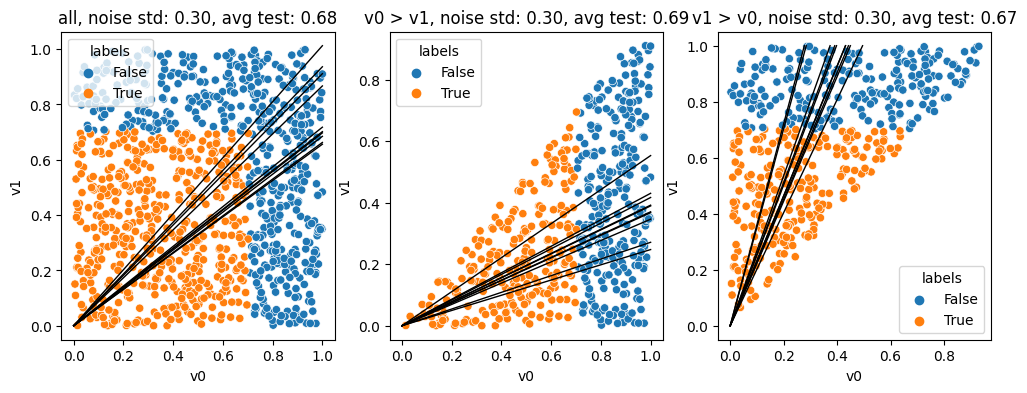

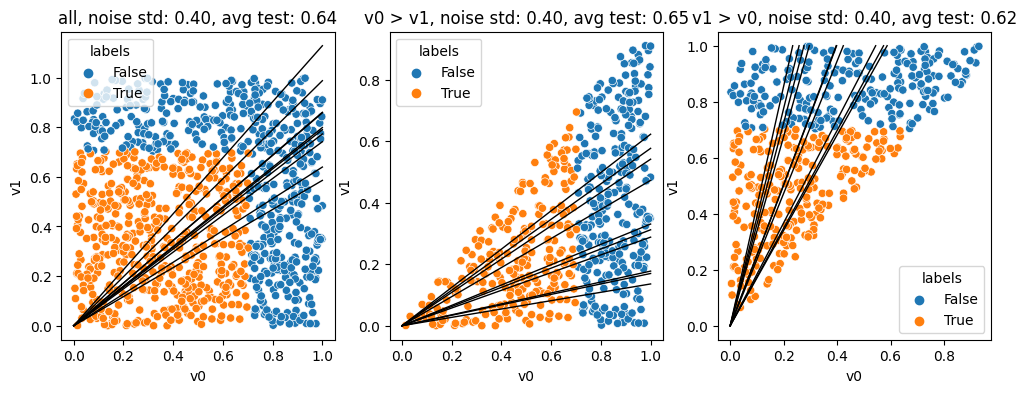

In [7]:
noise_levels = np.arange(0, 0.5, 0.1)
noise_level = 0
num_samples = 10
for noise_level in noise_levels:
    condition_vecs = []
    condition_test_scores = []
    for condition, idxs in enumerate(idxs_by_condition_w_all):
        vecs = np.empty((num_samples, num_vars))
        test_scores = np.empty(num_samples)
        for sample_idx in range(num_samples):
            frs = simulate_neural_activity(betas, vars, rng, noise_level)
            condition_frs = frs[:, idxs]
            condition_labels = labels[idxs]
            model, _, test_score, = train_model(condition_frs, condition_labels)
            vectors = model.coef_ @ betas
            vecs[sample_idx, :] = vectors
            test_scores[sample_idx] = test_score
        condition_vecs.append(vecs)
        condition_test_scores.append(np.mean(test_scores))
    fig, axs = plt.subplots(1, len(idxs_by_condition_w_all), figsize=(12, 4))
    for i, idxs in enumerate(idxs_by_condition_w_all):
        ax = axs[i]
        value_df = pd.DataFrame({"v0": vars[0, idxs], "v1": vars[1, idxs], "labels": labels[idxs]})
        sns.scatterplot(data=value_df, x="v0", y="v1", hue="labels", ax=ax)
        vec = condition_vecs[i]
        for sample_idx in range(num_samples):
            if condition_names[i] == "v1 > v0":
                y = np.arange(0, 1.1, 0.1)
                x = y * vec[sample_idx, 0] / vec[sample_idx, 1]
            else: 
                x = np.arange(0, 1.1, 0.1)
                y = x * vec[sample_idx, 1] / vec[sample_idx, 0]
            ax.plot(x, y, label="lr axis", color="black", linewidth=1)
        ax.set_title(f"{condition_names[i]}, noise std: {noise_level:.2f}, avg test: {condition_test_scores[i]:.2f}")

### Look at how differenc betweeen in vs cross condition decoding is affected by noise

In [ ]:
noise_levels = np.arange(0, 1, 0.05)
res = []
for noise_level in noise_levels:
    for sample in range(50):
        frs = simulate_neural_activity(betas, vars, rng, noise_level)
        in_res, cross_res, overall_res = evaluate_ccgp(frs, labels, idxs_by_condition, num_samples=1)
        in_res = [{"noise std": noise_level, "accuracy": res, "cond": "within cond"} for res in in_res]
        cross_res = [{"noise std": noise_level, "accuracy": res, "cond": "across conds"} for res in cross_res]
        overall_res = [{"noise std": noise_level, "accuracy": res, "cond": "overall"} for res in overall_res]

        res.extend(in_res + cross_res + overall_res) 
res = pd.DataFrame(res)

<Axes: xlabel='noise std', ylabel='accuracy'>

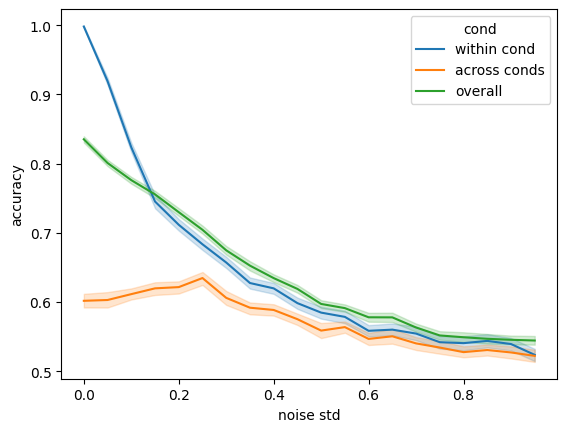

In [9]:
sns.lineplot(res, x="noise std", y="accuracy", hue="cond")

### One question: how do dot products of weights of two regressors as a function noise?

In [ ]:
num_samples = 50
noise_levels = np.arange(0, 1, 0.05)
sim_neural = []
sim_value = []
score_res = []
for noise_level in noise_levels:
    for sample in range(num_samples):
        frs = simulate_neural_activity(betas, vars, rng, noise_level)
        coefs = np.empty((num_units, num_vars))
        for condition in range(num_vars):
            idxs = idxs_by_condition[condition]
            condition_frs = frs[:, idxs]
            condition_labels = labels[idxs]

            model, train_score, test_score = train_model(condition_frs, condition_labels)
            score_res.append({"noise_std": noise_level, "sample": sample, "condition": f"Cond {condition} Train", "score": train_score})
            score_res.append({"noise_std": noise_level, "sample": sample, "condition": f"Cond {condition} Test", "score": test_score})
            coefs[:, condition] = model.coef_
        vec_a = coefs[:, 0] @ betas
        vec_b = coefs[:, 1] @ betas
        sim_value.append({"noise_std": noise_level, "sample": sample, "cosine similarity": calc_cosine_sim(vec_a, vec_b)})
        sim_neural.append({"noise_std": noise_level, "sample": sample, "cosine similarity": calc_cosine_sim(coefs[:, 0], coefs[:, 1])})
sim_value = pd.DataFrame(sim_value)
sim_neural = pd.DataFrame(sim_neural)
score_res = pd.DataFrame(score_res)

Text(0.5, 1.0, 'cosine sim of decoding axes between two conditions')

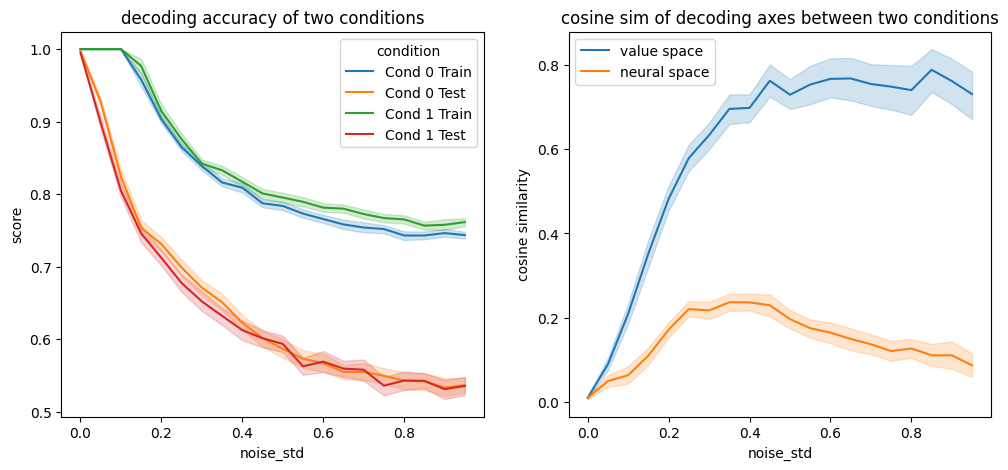

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
sns.lineplot(score_res, x="noise_std", y="score", hue="condition", ax=ax)
ax.set_title("decoding accuracy of two conditions")

ax = axs[1]
sns.lineplot(sim_value, x="noise_std", y="cosine similarity", ax=ax, label="value space")
sns.lineplot(sim_neural, x="noise_std", y="cosine similarity", ax=ax, label="neural space")
ax.set_title("cosine sim of decoding axes between two conditions")

### What if beta vectors not orthogonal?

In [ ]:
res = []
noise_levels = np.arange(0, 0.5, 0.05)
# noise_levels = [0]
for noise_level in noise_levels:
    for angle_idx in range(13):
        theta = np.pi / 2 - angle_idx * (np.pi/ 24)
        for sample in range(20):
            betas = get_two_betas_with_angle(num_units, theta)
            frs = simulate_neural_activity(betas, vars, rng, noise_level)
            in_res, cross_res, overall_res = evaluate_ccgp(frs, labels, idxs_by_condition, num_samples=1)
            in_res = [{"noise std": noise_level, "angle_idx": angle_idx, "accuracy": res, "cond": "within cond"} for res in in_res]
            cross_res = [{"noise std": noise_level, "angle_idx": angle_idx, "accuracy": res, "cond": "across conds"} for res in cross_res]
            overall_res = [{"noise std": noise_level, "angle_idx": angle_idx, "accuracy": res, "cond": "overall"} for res in overall_res]
            res.extend(in_res + cross_res + overall_res) 
res = pd.DataFrame(res)

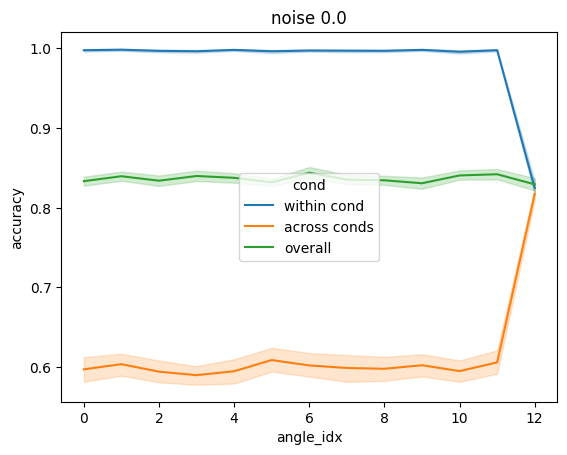

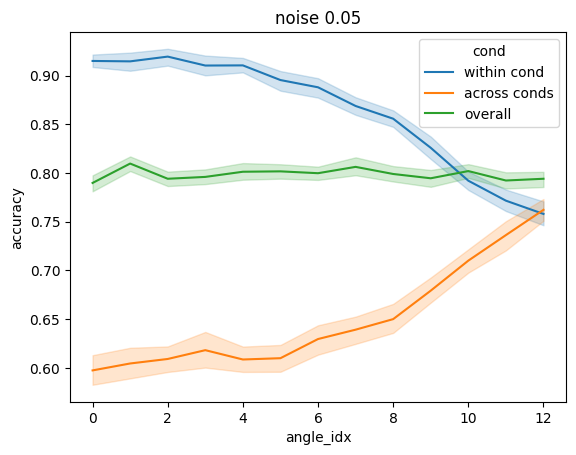

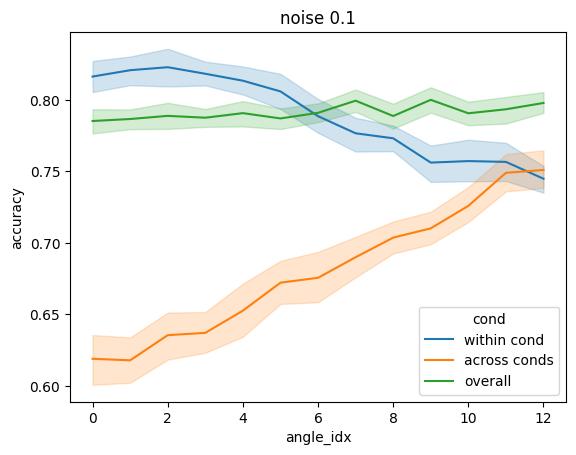

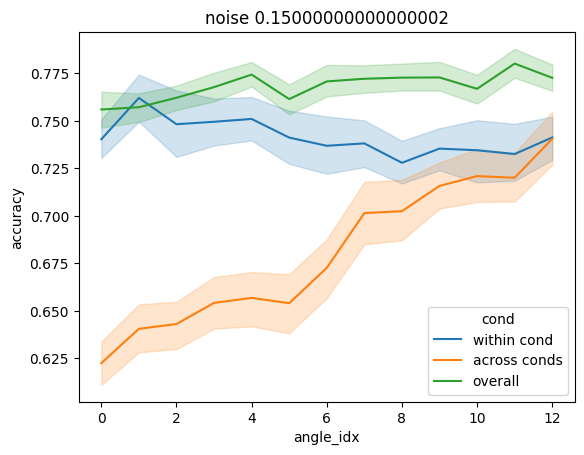

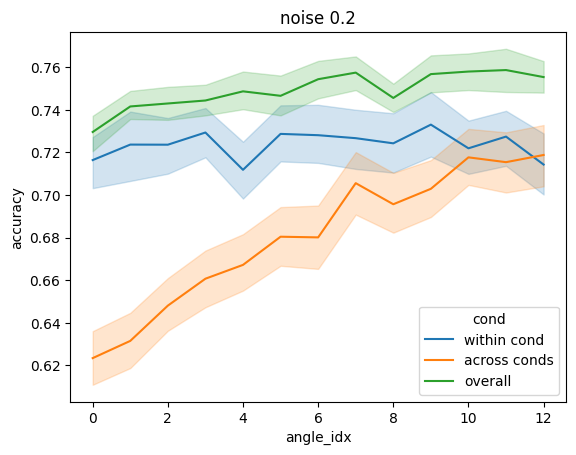

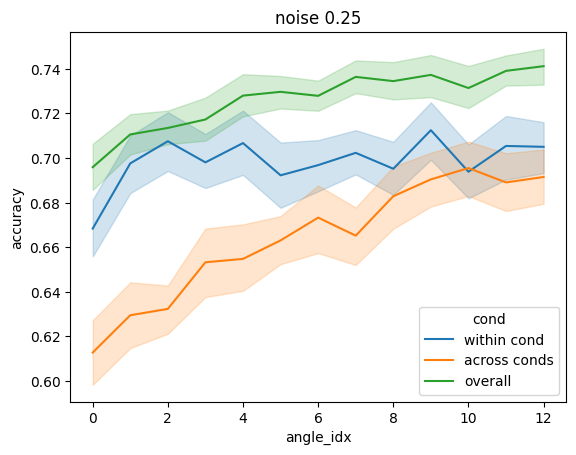

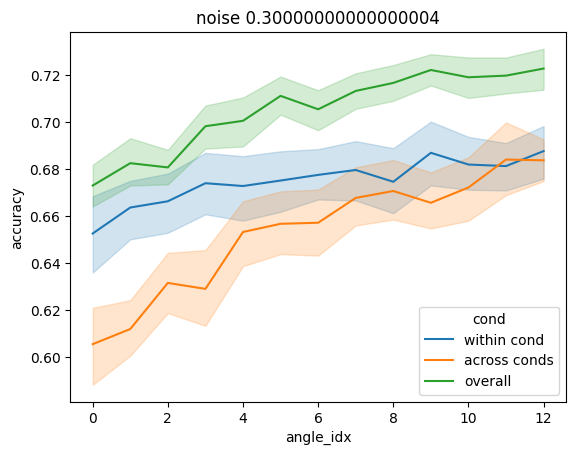

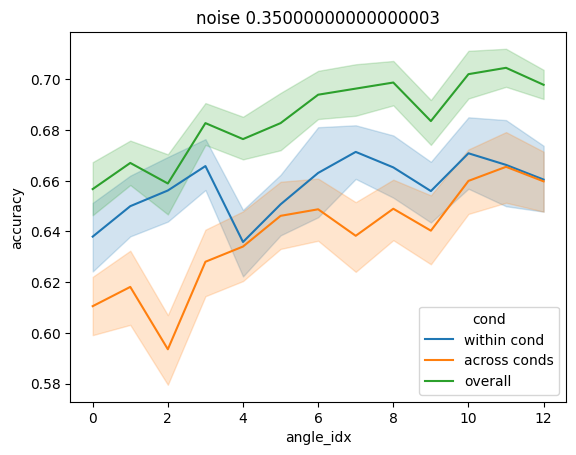

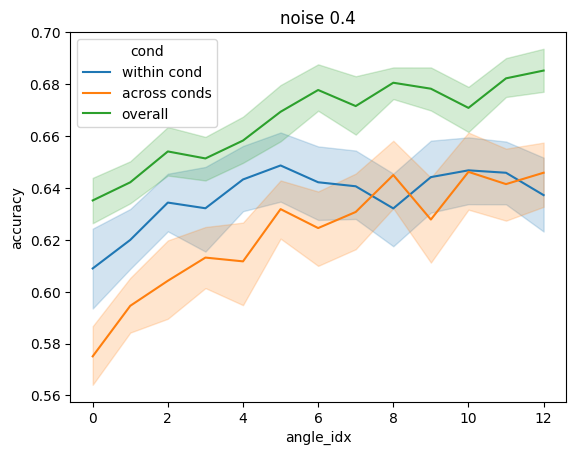

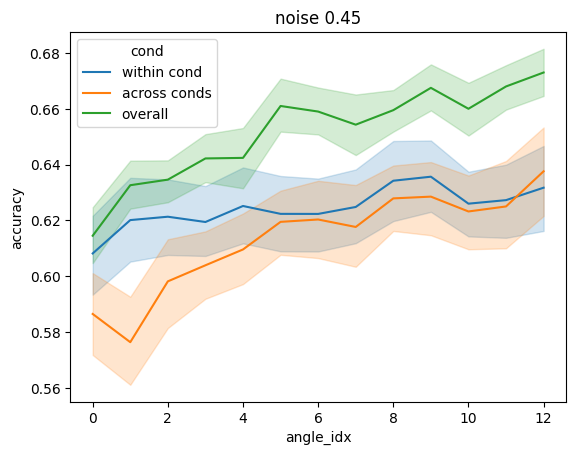

In [13]:
for noise_level in noise_levels:
    fig, ax = plt.subplots()
    sub_res = res[res["noise std"] == noise_level]
    sns.lineplot(sub_res, x="angle_idx", y="accuracy", hue="cond", ax=ax)
    ax.set_title(f"noise {noise_level}")

### What is "confidence" is defined using entropy?


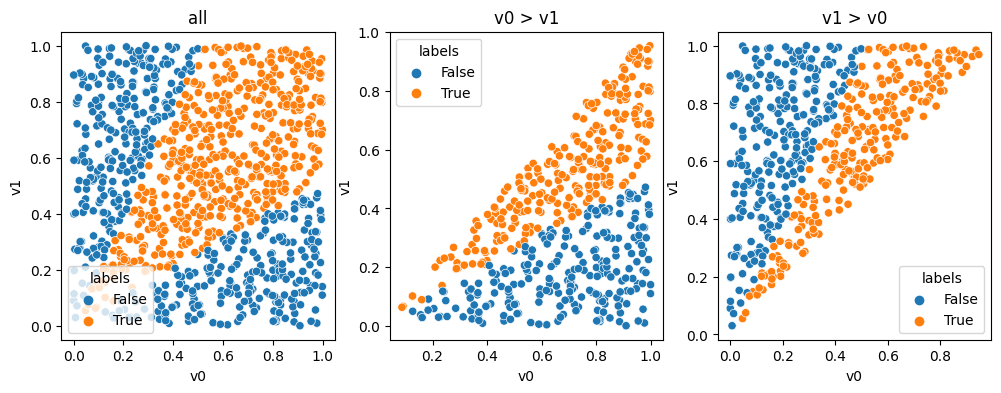

In [5]:
num_units = 100
num_vars = 2
num_trials = 1000
rng = np.random.default_rng()
vars = get_random_values(num_trials, 2, rng)
labels = get_labels_entropy(vars)
betas = get_orthogonal_betas(num_units, num_vars)
idxs_by_condition = get_idxs_by_condition(vars)
idxs_by_condition_w_all = [np.arange(vars.shape[1])] + idxs_by_condition
condition_names = ["all", "v0 > v1", "v1 > v0"]
fig, axs = plt.subplots(1, len(idxs_by_condition_w_all), figsize=(12, 4))
for i, idxs in enumerate(idxs_by_condition_w_all):
    ax = axs[i]
    value_df = pd.DataFrame({"v0": vars[0, idxs], "v1": vars[1, idxs], "labels": labels[idxs]})
    sns.scatterplot(data=value_df, x="v0", y="v1", hue="labels", ax=ax)
    ax.set_title(condition_names[i])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

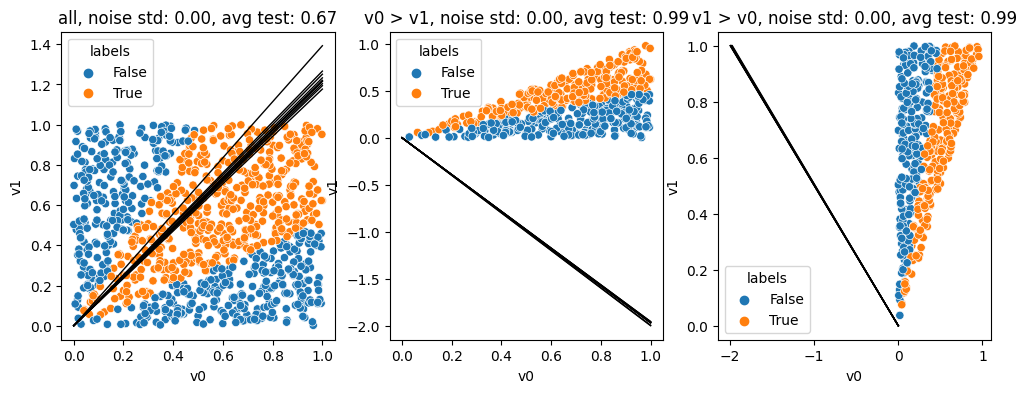

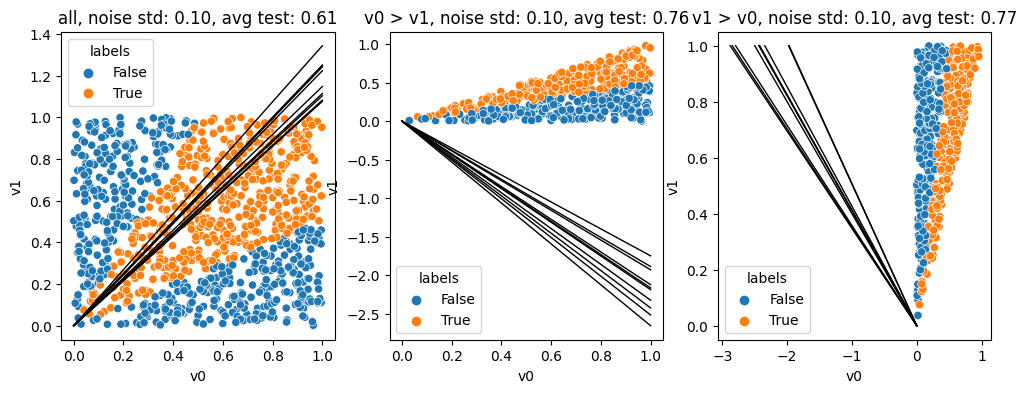

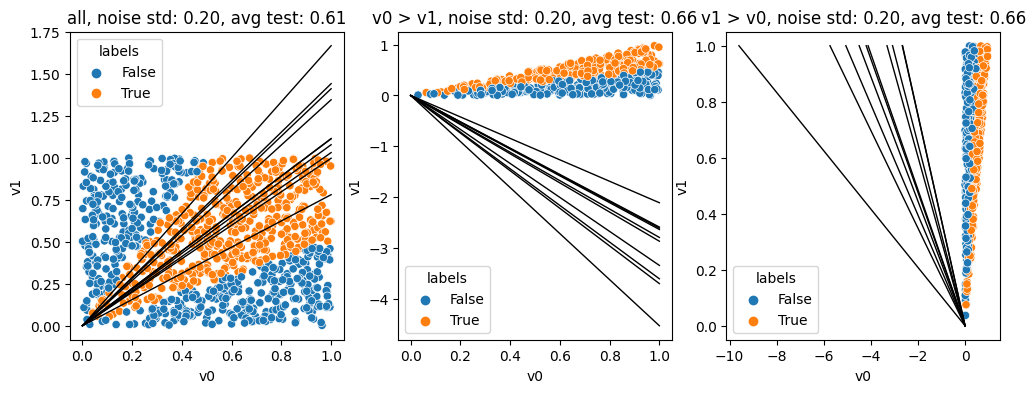

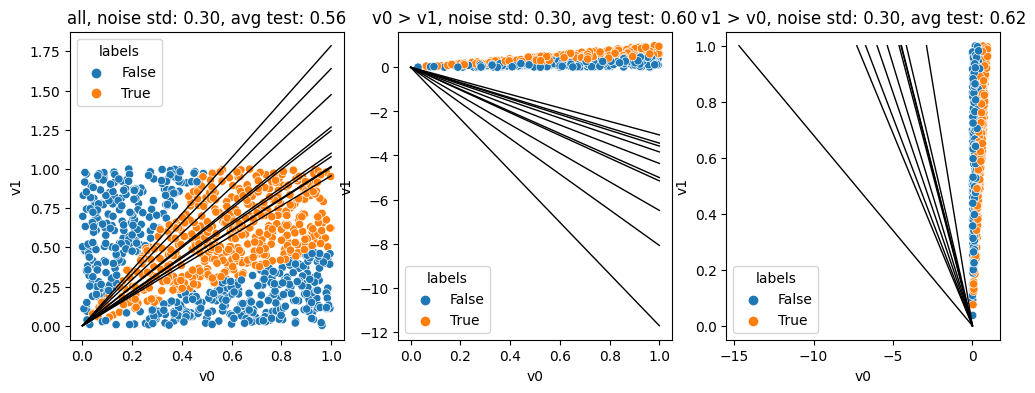

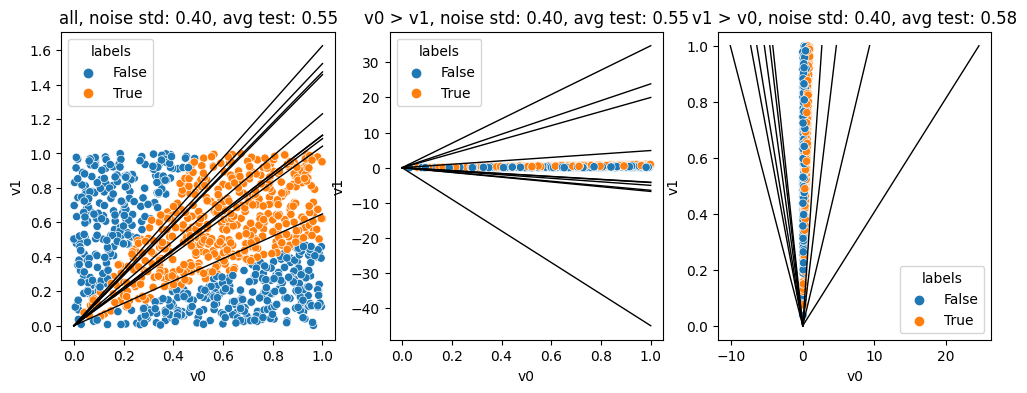

In [9]:
noise_levels = np.arange(0, 0.5, 0.1)
noise_level = 0
num_samples = 10
for noise_level in noise_levels:
    condition_vecs = []
    condition_test_scores = []
    for condition, idxs in enumerate(idxs_by_condition_w_all):
        vecs = np.empty((num_samples, num_vars))
        test_scores = np.empty(num_samples)
        for sample_idx in range(num_samples):
            frs = simulate_neural_activity(betas, vars, rng, noise_level)
            condition_frs = frs[:, idxs]
            condition_labels = labels[idxs]
            model, _, test_score, = train_model(condition_frs, condition_labels)
            vectors = model.coef_ @ betas
            vecs[sample_idx, :] = vectors
            test_scores[sample_idx] = test_score
        condition_vecs.append(vecs)
        condition_test_scores.append(np.mean(test_scores))
    fig, axs = plt.subplots(1, len(idxs_by_condition_w_all), figsize=(12, 4))
    for i, idxs in enumerate(idxs_by_condition_w_all):
        ax = axs[i]
        value_df = pd.DataFrame({"v0": vars[0, idxs], "v1": vars[1, idxs], "labels": labels[idxs]})
        sns.scatterplot(data=value_df, x="v0", y="v1", hue="labels", ax=ax)
        vec = condition_vecs[i]
        for sample_idx in range(num_samples):
            if condition_names[i] == "v1 > v0":
                y = np.arange(0, 1.1, 0.1)
                x = y * vec[sample_idx, 0] / vec[sample_idx, 1]
            else: 
                x = np.arange(0, 1.1, 0.1)
                y = x * vec[sample_idx, 1] / vec[sample_idx, 0]
            ax.plot(x, y, label="lr axis", color="black", linewidth=1)
        ax.set_title(f"{condition_names[i]}, noise std: {noise_level:.2f}, avg test: {condition_test_scores[i]:.2f}")

In [ ]:
noise_levels = np.arange(0, 1, 0.05)
res = []
for noise_level in noise_levels:
    for sample in range(50):
        frs = simulate_neural_activity(betas, vars, rng, noise_level)
        in_res, cross_res, overall_res = evaluate_ccgp(frs, labels, idxs_by_condition, num_samples=1)
        in_res = [{"noise std": noise_level, "accuracy": res, "cond": "within cond"} for res in in_res]
        cross_res = [{"noise std": noise_level, "accuracy": res, "cond": "across conds"} for res in cross_res]
        overall_res = [{"noise std": noise_level, "accuracy": res, "cond": "overall"} for res in overall_res]
        res.extend(in_res + cross_res + overall_res) 
res = pd.DataFrame(res)

<Axes: xlabel='noise std', ylabel='accuracy'>

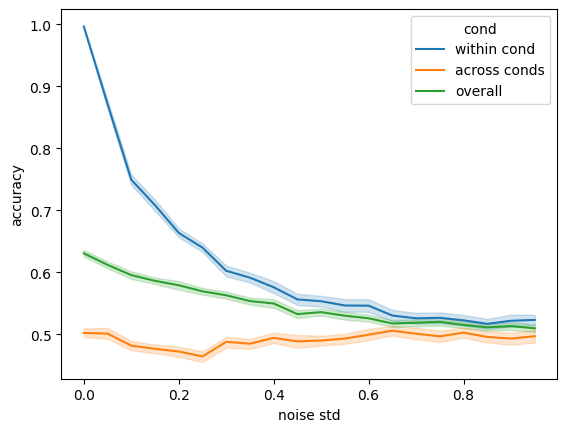

In [9]:
sns.lineplot(res, x="noise std", y="accuracy", hue="cond")

### Betas not orthogonal (feature entropy as confidence)

In [ ]:
res = []
noise_levels = np.arange(0, 0.5, 0.05)
# noise_levels = [0]
for noise_level in noise_levels:
    for angle_idx in range(13):
        theta = np.pi / 2 - angle_idx * (np.pi/ 24)
        for sample in range(20):
            betas = get_two_betas_with_angle(num_units, theta)
            frs = simulate_neural_activity(betas, vars, rng, noise_level)
            in_res, cross_res, overall_res = evaluate_ccgp(frs, labels, idxs_by_condition, num_samples=1)
            in_res = [{"noise std": noise_level, "angle_idx": angle_idx, "accuracy": res, "cond": "within cond"} for res in in_res]
            cross_res = [{"noise std": noise_level, "angle_idx": angle_idx, "accuracy": res, "cond": "across conds"} for res in cross_res]
            overall_res = [{"noise std": noise_level, "angle_idx": angle_idx, "accuracy": res, "cond": "overall"} for res in overall_res]
            res.extend(in_res + cross_res + overall_res) 
res = pd.DataFrame(res)

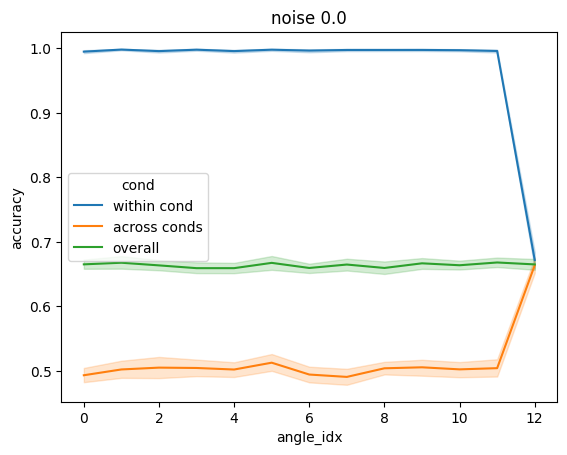

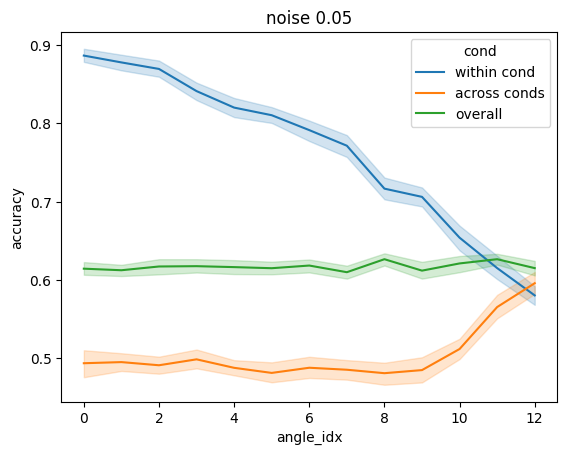

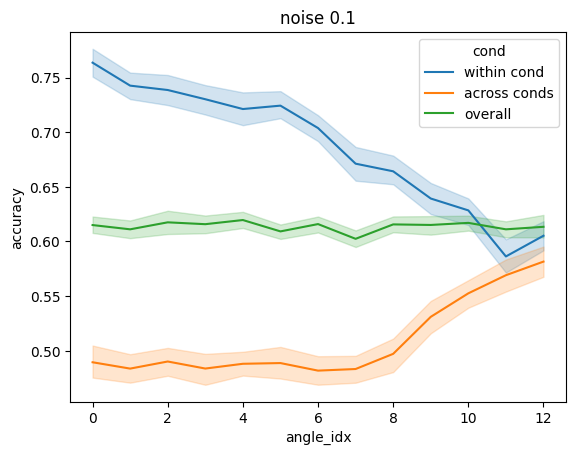

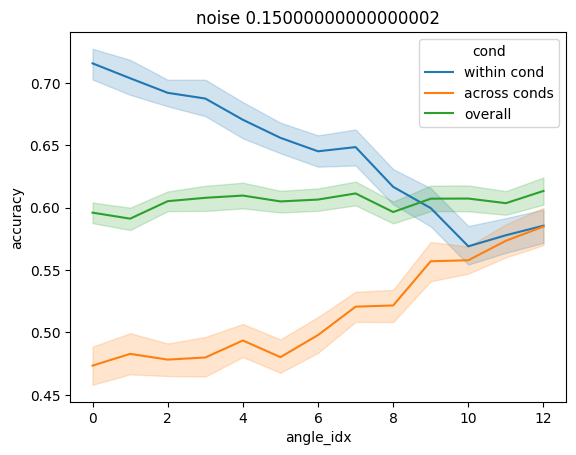

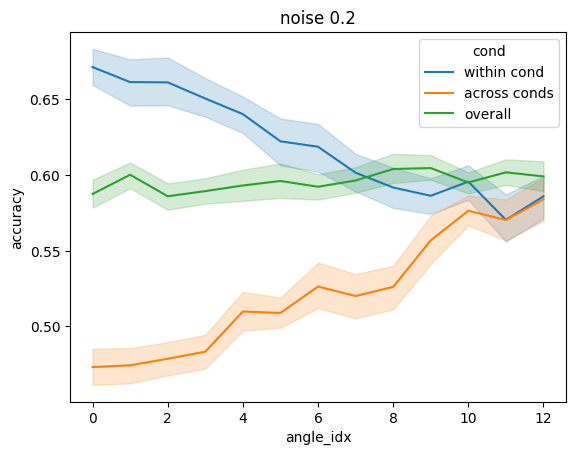

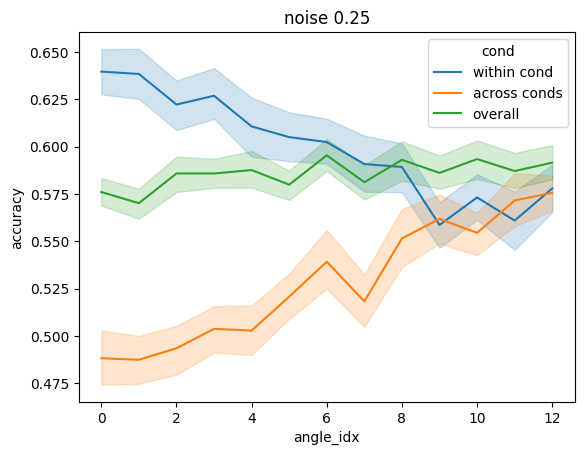

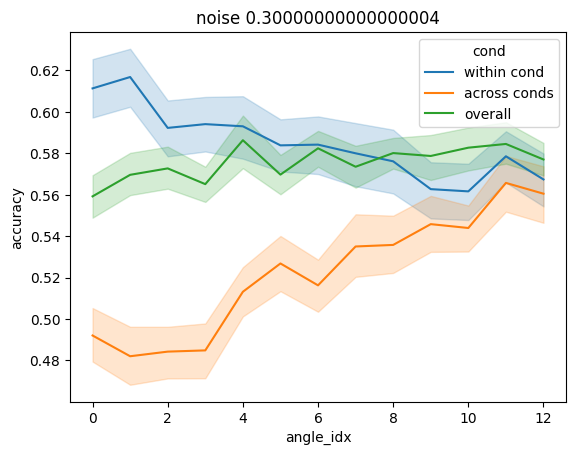

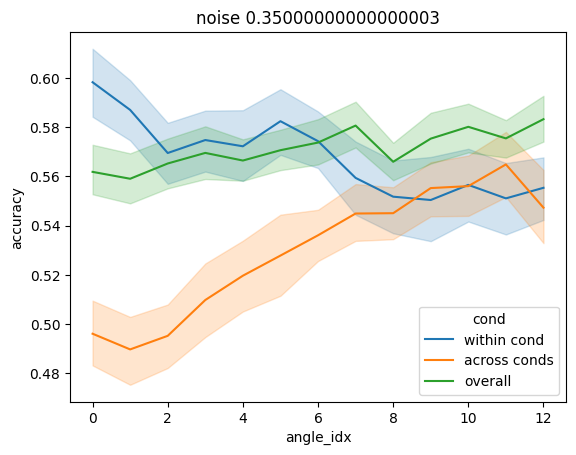

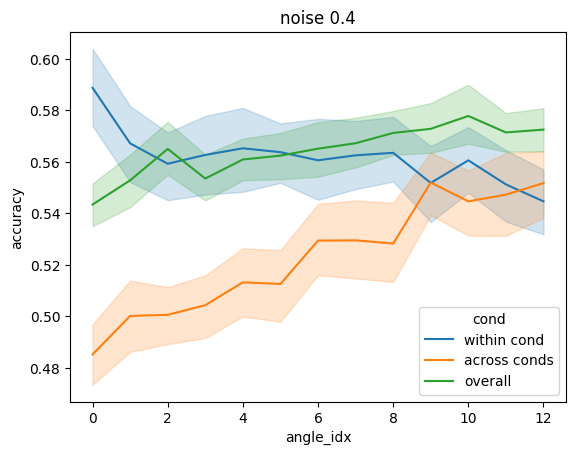

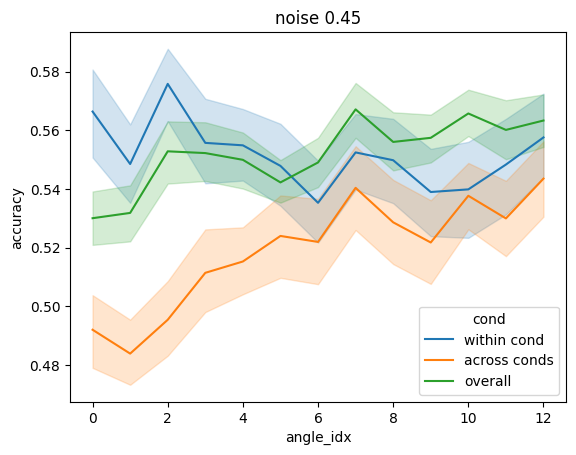

In [7]:
for noise_level in noise_levels:
    fig, ax = plt.subplots()
    sub_res = res[res["noise std"] == noise_level]
    sns.lineplot(sub_res, x="angle_idx", y="accuracy", hue="cond", ax=ax)
    ax.set_title(f"noise {noise_level}")

### What if Gaussian values? Confidence metric is distance?

In [5]:
num_units = 100
num_vars = 2
num_trials = 1000
rng = np.random.default_rng()
vars = get_random_values_gaussian(num_trials, 2, rng)
labels = get_labels_dist(vars)
idxs_by_condition = get_idxs_by_condition(vars)
idxs_by_condition_w_all = [np.arange(vars.shape[1])] + idxs_by_condition
condition_names = ["all", "v0 > v1", "v1 > v0"]

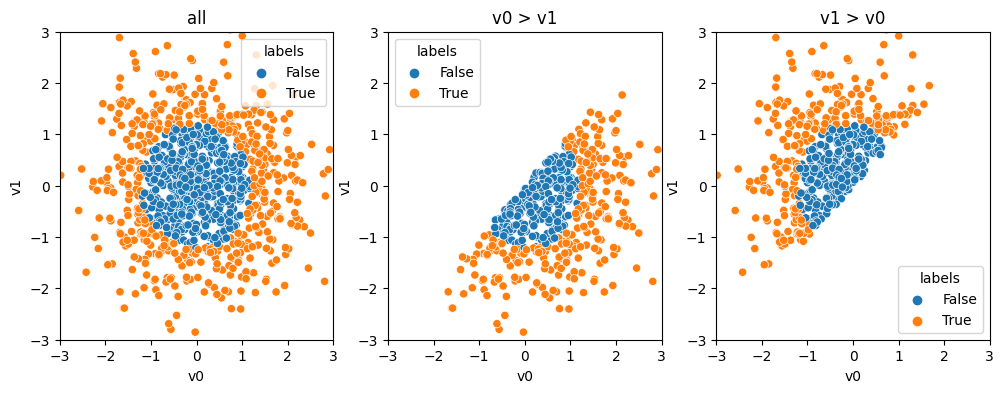

In [8]:
fig, axs = plt.subplots(1, len(idxs_by_condition_w_all), figsize=(12, 4))
for i, idxs in enumerate(idxs_by_condition_w_all):
    ax = axs[i]
    value_df = pd.DataFrame({"v0": vars[0, idxs], "v1": vars[1, idxs], "labels": labels[idxs]})
    sns.scatterplot(data=value_df, x="v0", y="v1", hue="labels", ax=ax)
    ax.set_title(condition_names[i])
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])


### Axes as a function of noise?

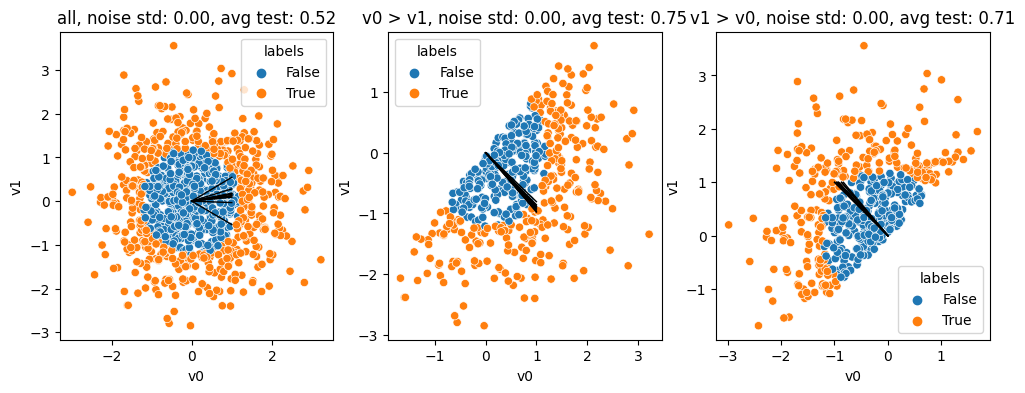

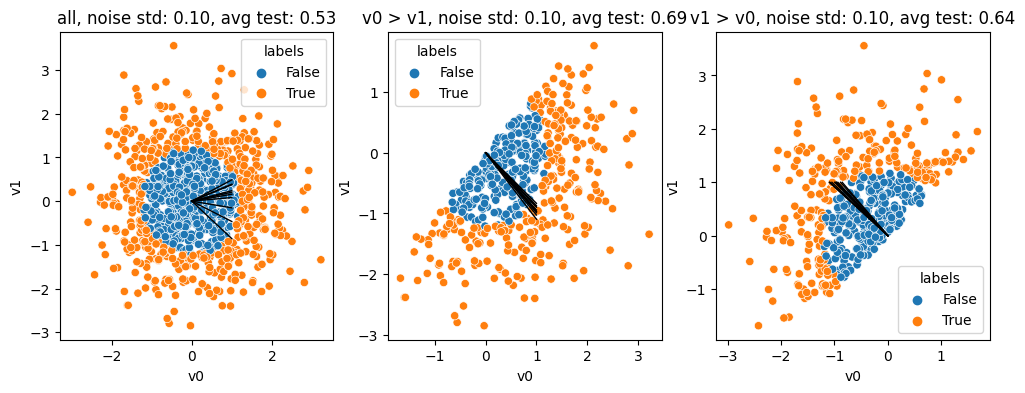

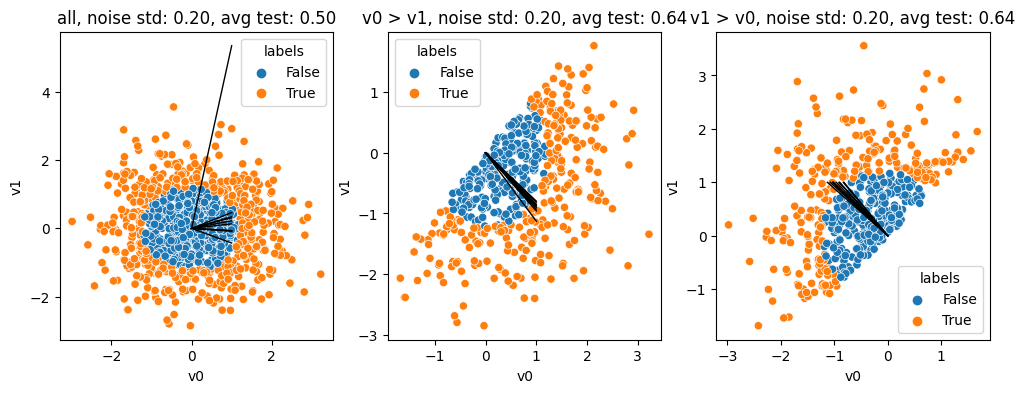

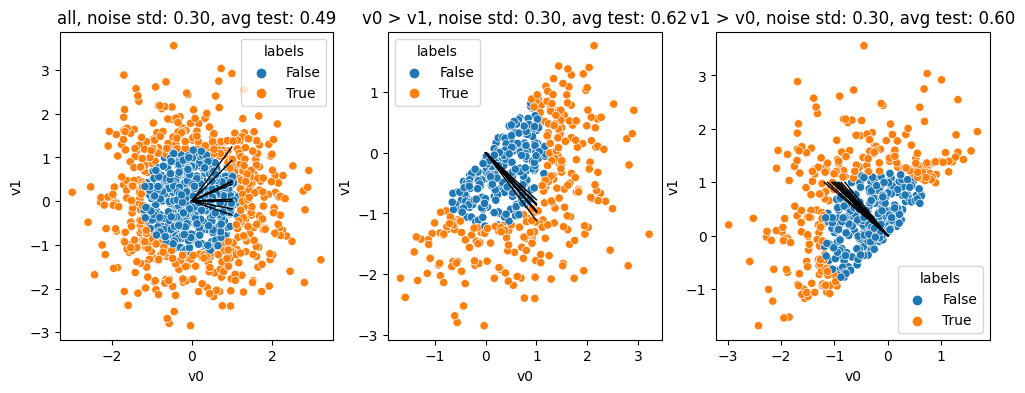

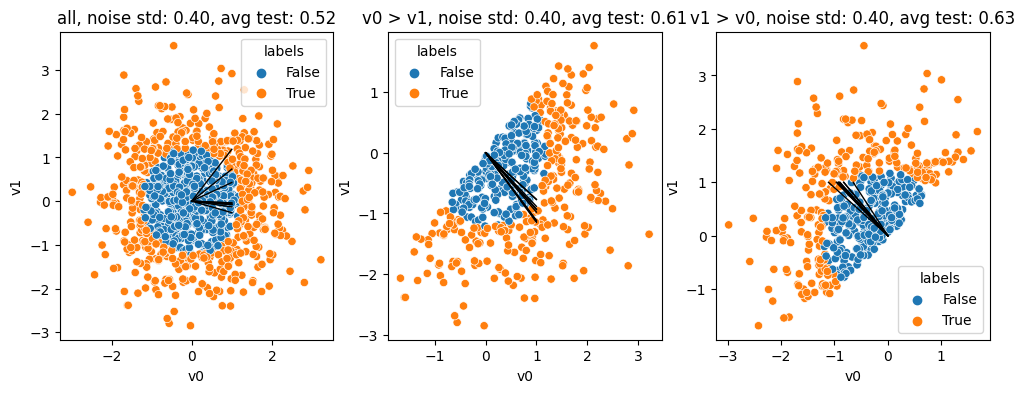

In [10]:
betas = get_orthogonal_betas(num_units, num_vars)
frs = simulate_neural_activity(betas, vars, rng, 2)

noise_levels = np.arange(0, 0.5, 0.1)
noise_level = 0
num_samples = 10
for noise_level in noise_levels:
    condition_vecs = []
    condition_test_scores = []
    for condition, idxs in enumerate(idxs_by_condition_w_all):
        vecs = np.empty((num_samples, num_vars))
        test_scores = np.empty(num_samples)
        for sample_idx in range(num_samples):
            frs = simulate_neural_activity(betas, vars, rng, noise_level)
            condition_frs = frs[:, idxs]
            condition_labels = labels[idxs]
            model, _, test_score, = train_model(condition_frs, condition_labels)
            vectors = model.coef_ @ betas
            vecs[sample_idx, :] = vectors
            test_scores[sample_idx] = test_score
        condition_vecs.append(vecs)
        condition_test_scores.append(np.mean(test_scores))
    fig, axs = plt.subplots(1, len(idxs_by_condition_w_all), figsize=(12, 4))
    for i, idxs in enumerate(idxs_by_condition_w_all):
        ax = axs[i]
        value_df = pd.DataFrame({"v0": vars[0, idxs], "v1": vars[1, idxs], "labels": labels[idxs]})
        sns.scatterplot(data=value_df, x="v0", y="v1", hue="labels", ax=ax)
        vec = condition_vecs[i]
        for sample_idx in range(num_samples):
            if condition_names[i] == "v1 > v0":
                y = np.arange(0, 1.1, 0.1)
                x = y * vec[sample_idx, 0] / vec[sample_idx, 1]
            else: 
                x = np.arange(0, 1.1, 0.1)
                y = x * vec[sample_idx, 1] / vec[sample_idx, 0]
            ax.plot(x, y, label="lr axis", color="black", linewidth=1)
        ax.set_title(f"{condition_names[i]}, noise std: {noise_level:.2f}, avg test: {condition_test_scores[i]:.2f}")

In [ ]:
noise_levels = np.arange(0, 1, 0.05)
res = []
for noise_level in noise_levels:
    for sample in range(50):
        frs = simulate_neural_activity(betas, vars, rng, noise_level)
        in_res, cross_res, overall_res = evaluate_ccgp(frs, labels, idxs_by_condition, num_samples=1)
        in_res = [{"noise std": noise_level, "accuracy": res, "cond": "within cond"} for res in in_res]
        cross_res = [{"noise std": noise_level, "accuracy": res, "cond": "across conds"} for res in cross_res]
        overall_res = [{"noise std": noise_level, "accuracy": res, "cond": "overall"} for res in overall_res]

        res.extend(in_res + cross_res + overall_res) 
res = pd.DataFrame(res)

<Axes: xlabel='noise std', ylabel='accuracy'>

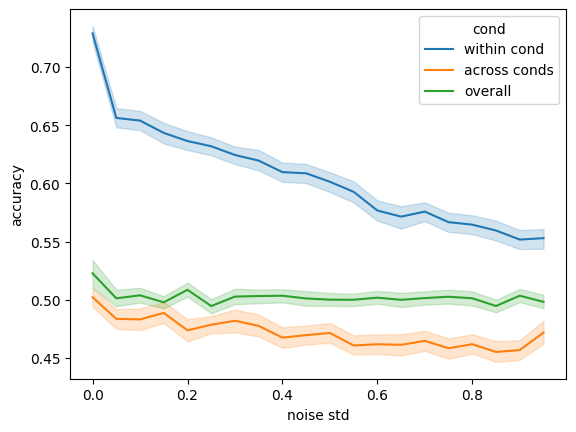

In [12]:
sns.lineplot(res, x="noise std", y="accuracy", hue="cond")

In [ ]:
res = []
noise_levels = np.arange(0, 0.5, 0.05)
# noise_levels = [0]
for noise_level in noise_levels:
    for angle_idx in range(13):
        theta = np.pi / 2 - angle_idx * (np.pi/ 24)
        for sample in range(20):
            betas = get_two_betas_with_angle(num_units, theta)
            frs = simulate_neural_activity(betas, vars, rng, noise_level)
            in_res, cross_res, overall_res = evaluate_ccgp(frs, labels, idxs_by_condition, num_samples=1)
            in_res = [{"noise std": noise_level, "angle_idx": angle_idx, "accuracy": res, "cond": "within cond"} for res in in_res]
            cross_res = [{"noise std": noise_level, "angle_idx": angle_idx, "accuracy": res, "cond": "across conds"} for res in cross_res]
            overall_res = [{"noise std": noise_level, "angle_idx": angle_idx, "accuracy": res, "cond": "overall"} for res in overall_res]
            res.extend(in_res + cross_res + overall_res) 
res = pd.DataFrame(res)

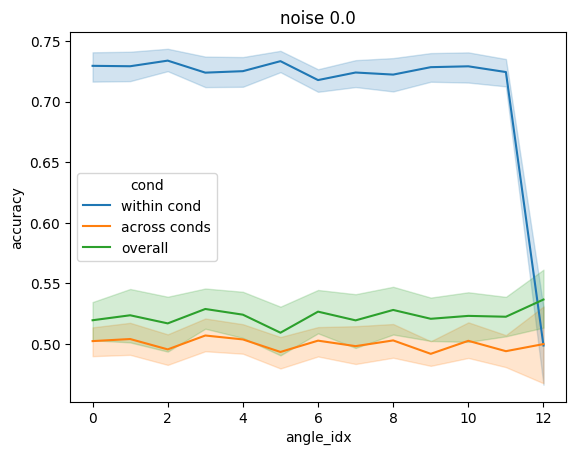

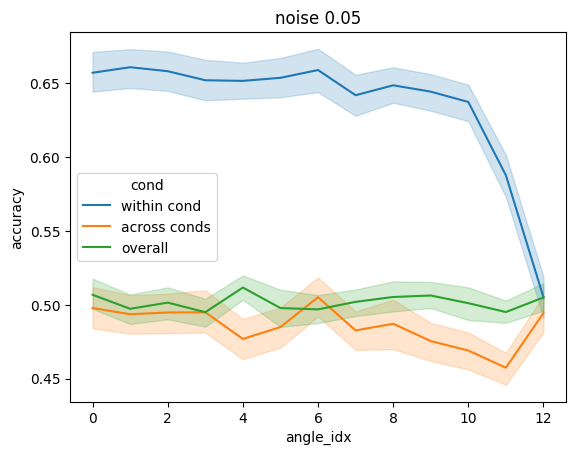

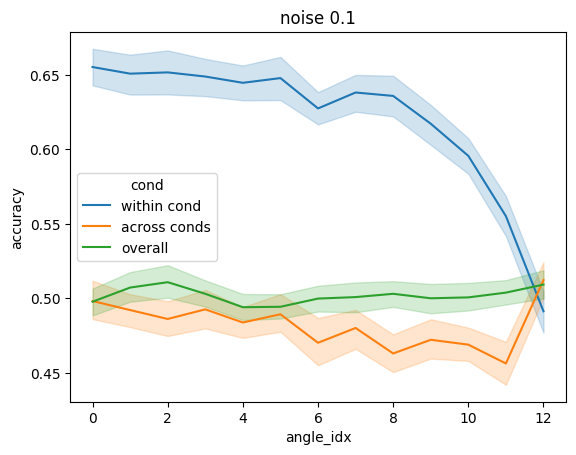

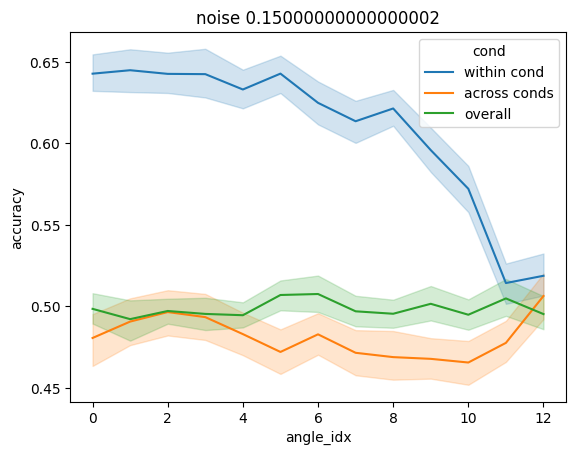

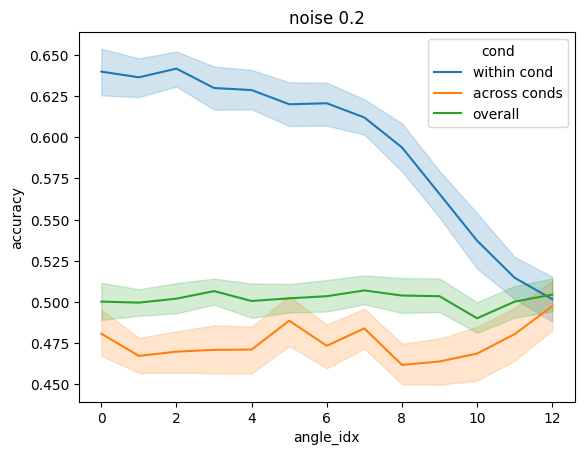

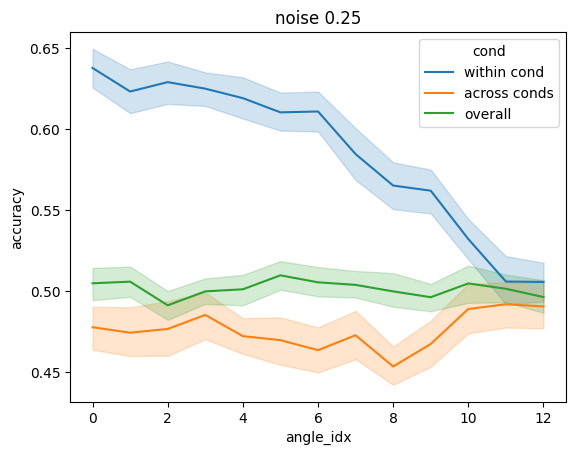

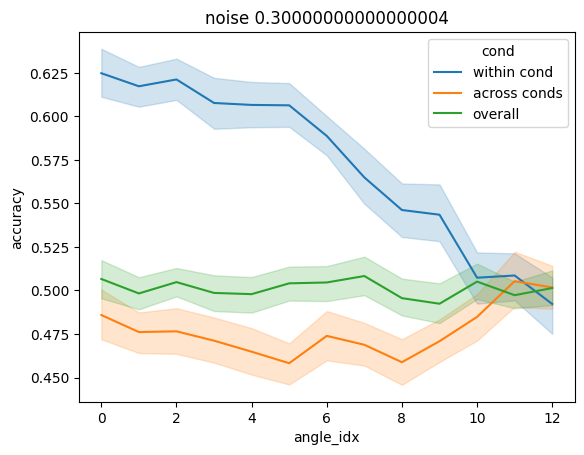

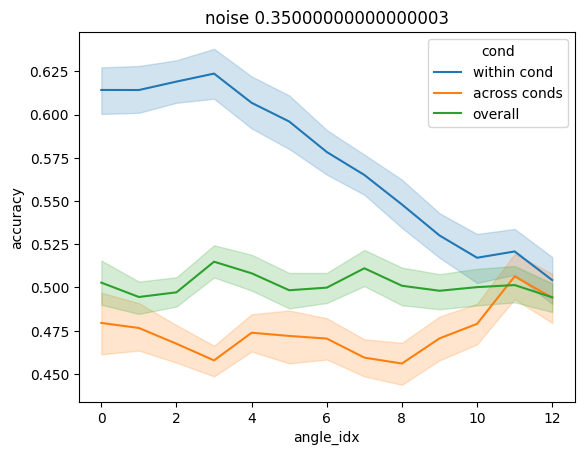

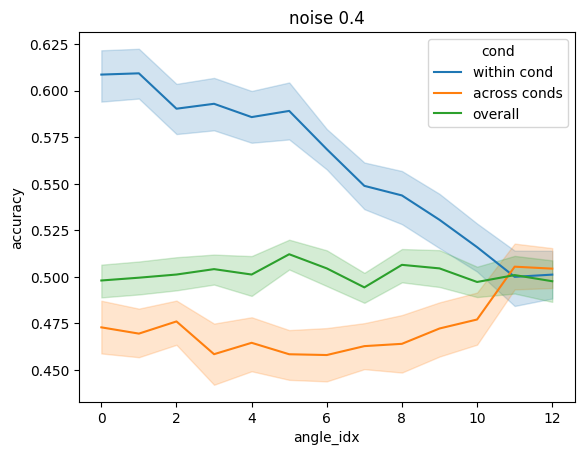

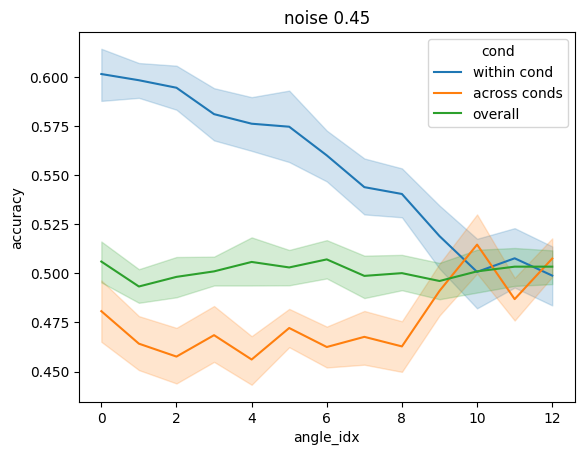

In [14]:
for noise_level in noise_levels:
    fig, ax = plt.subplots()
    sub_res = res[res["noise std"] == noise_level]
    sns.lineplot(sub_res, x="angle_idx", y="accuracy", hue="cond", ax=ax)
    ax.set_title(f"noise {noise_level}")